In [1]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import pandas as pd
import numpy as np
import csv
import MeCab
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import re
import neologdn
import demoji
import emoji
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
import japanize_matplotlib

model_dir = '/Users/iomacbookair2/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
# model_dir = '/Users/labimac/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
model_word2vec = KeyedVectors.load_word2vec_format(model_dir, binary=True)
mecab = MeCab.Tagger(
    '-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')


In [2]:
path = "/Users/iomacbookair2/Documents/lab/DEIM2023/experiment1/annkw/220116_annkw_exp1.csv"
df = pd.read_csv((path))
df.sort_values(by = 'created_at', ascending = True, inplace = True)
df = df.reset_index(drop=True)
df['created_at'] = pd.to_datetime(df['created_at'])
df

,created_at,text
0,2022-01-16 02:12:00,うお！！！！この時間にROSYは寝れん！！！！#annkw #SixTONESANN
1,2022-01-16 02:12:01,Rosyやん！🤙 #annkw
2,2022-01-16 02:12:08,ストだ。 #annkw
3,2022-01-16 02:12:08,ロージー！！ #annkw
4,2022-01-16 02:12:09,『Rosy』 #annkw
...,...,...
1949,2022-01-16 02:34:53,山梨の方に旅行か^ ^ #annkw
1950,2022-01-16 02:34:53,山梨の別荘に向かって春日家 1泊2日の旅。 #annkw
1951,2022-01-16 02:34:54,春日トークゾーンって、チンやれるの？ #annkw
1952,2022-01-16 02:34:56,正月旅行の話(…時間大丈夫かな？)#annkw


In [3]:
def preprocess(text):
    text = emoji.replace_emoji(text, replace=' ')
    text = re.sub(r'#\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'＃\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'@\S+', '', text) # @を消す
    text = re.sub(r'http?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text) # URLをスペースに置き換え
    text = re.sub(r'https?://\S+', ' ', text) # URLをスペースに置き換え
    text = re.sub(r'!-/:-@[-`{-~]', r'', text) # 記号を消す
    text = re.sub(r'”', '', text)  # "を消す
    text = re.sub(r'"', '', text)  # "を消す
    text = re.sub(r"'", "", text) # 'を消す
    text = re.sub(r'[(`)]', '', text)
    text = re.sub(
        "[\uFF01-\uFF0F\uFF1A-\uFF20\uFF3B-\uFF40\uFF5B-\uFF65\u3000-\u303F]", '', text)  # 記号を消す
    text = re.sub(
        u'[■♯【】「」『』;・ㅂﾟˊᗜ┏━┓┗┛ヾθ、│/`:@`{-~。|∀!〇╰`′‵ˋω.*…╭∇^_￣´｀•˘д↑艸╯→°д̀ᴗ˃˂⁽⁾φ└＼※彡𖥦←ꂹ]', '', text)  # 記号を消す
    text = re.sub(r'(\d)([,.])(\d+)', r'\1\3', text) # 小数点とカンマを消す
    text = re.sub(r'\d+', '0', text) # 数字を0に置き換え
    text = text.lower() # 英字を小文字に
    text = re.sub(r"[\u3000\t\r\n]", " ", text) # 空白文字をスペースに置き換え
    text = neologdn.normalize(text)
    return text


df['text'] = df['text'].apply(preprocess)
df


,created_at,text
0,2022-01-16 02:12:00,うおこの時間にrosyは寝れん
1,2022-01-16 02:12:01,rosyやん
2,2022-01-16 02:12:08,ストだ
3,2022-01-16 02:12:08,ロージー
4,2022-01-16 02:12:09,rosy
...,...,...
1949,2022-01-16 02:34:53,山梨の方に旅行か
1950,2022-01-16 02:34:53,山梨の別荘に向かって春日家0泊0日の旅
1951,2022-01-16 02:34:54,春日トークゾーンってチンやれるの
1952,2022-01-16 02:34:56,正月旅行の話時間大丈夫かな


In [4]:
# df.to_csv('preprocessed.csv', index=False)

In [5]:
import requests

url = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
r = requests.get(url)
tmp = r.text.split('\r\n')
stopwords = []
for i in range(len(tmp)):
    if len(tmp[i]) < 1:
        continue
    stopwords.append(tmp[i])

# stopwords += ["w", "ww", "www", "wwww", "wwwww", "笑",
#               "の", "し", "さ", "て", "れ", "ない", "てる",]

In [6]:
def words_list(sentence, model, mecab):
    if not sentence:
      pass
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
    #     filtered_words = [
    #         word for word in sentence_words if word not in stopwords]
    # return filtered_words
    return sentence_words


df["words"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else words_list(x, model_word2vec, mecab))
df


,created_at,text,words
0,2022-01-16 02:12:00,うおこの時間にrosyは寝れん,"[時間, rosy, 寝れ]"
1,2022-01-16 02:12:01,rosyやん,[rosy]
2,2022-01-16 02:12:08,ストだ,[スト]
3,2022-01-16 02:12:08,ロージー,[ロージー]
4,2022-01-16 02:12:09,rosy,[rosy]
...,...,...,...
1949,2022-01-16 02:34:53,山梨の方に旅行か,"[山梨, 方, 旅行]"
1950,2022-01-16 02:34:53,山梨の別荘に向かって春日家0泊0日の旅,"[山梨, 別荘, 向かっ, 春日家, 0, 泊, 0, 日, 旅]"
1951,2022-01-16 02:34:54,春日トークゾーンってチンやれるの,"[春日, トーク, ゾーン, チン, やれる]"
1952,2022-01-16 02:34:56,正月旅行の話時間大丈夫かな,"[正月, 旅行, 話, 時間, 大丈夫]"


In [7]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_words = pd.DataFrame({
    "words": groups.apply(lambda x: [word for sublist in x["words"] if type(sublist) == list for word in sublist])
})
df_words = df_words.reset_index()
df_words


,created_at,words
0,2022-01-16 02:12:00,"[時間, rosy, 寝れ, rosy, スト, ロージー, rosy, おおー, rosy..."
1,2022-01-16 02:13:00,"[流石に, もう少し, 喋っ, くれ, w, 再開, 若林, さん, トーク, ゾーン, あ..."
2,2022-01-16 02:14:00,"[若林, さん, トーク, ゾーン, 延長, w, 春日, ピアニッシモ, めちゃくちゃ, ..."
3,2022-01-16 02:15:00,"[若様, トーク, ゾーン, でかい, 仕事, 後, 葉巻, モテ, ないし, のど, 痛い..."
4,2022-01-16 02:16:00,"[出待ち, 対策, マスク, 買い, 行っ, w, おいでおいで, たりき, 春日, さん,..."
5,2022-01-16 02:17:00,"[商品価格, 0円, 本日, トレンド, 東日本大震災, 気, なる, 評判, おすすめ, ..."
6,2022-01-16 02:18:00,"[紙, タバコ, 天然, 物的, 感覚, の, w, トロピカルメンソール, 頭, パァー,..."
7,2022-01-16 02:19:00,"[電子タバコ, 吸っ, て, 紙, タバコ, 人, 喫煙所, 入っ, き, かみ, こす, ..."
8,2022-01-16 02:20:00,"[電子, ニオイ, 付き, にくい, の, なるへそ, 私, iqos, 匂い, 方, 苦手..."
9,2022-01-16 02:21:00,"[紙, 電子, タバコ, 臭い, 笑, by, 非喫煙者, 水曜日, 終わり, 加藤浩次, ..."


In [8]:
# df_words.to_csv('words.csv', index=False)

In [9]:
def save_wordclowd(words, index):
    if len(words) == 0:
        plt.axis("off")
    else:
        wordcloud = WordCloud(background_color="white", width=600, height=400, min_font_size=15,
                              font_path='/Users/iomacbookair2/Library/Fonts/IBMPlexSansJP-Regular.otf').generate(' '.join(words))
        plt.axis("off")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.savefig(f"{index+1}.png")
    plt.clf()


df_words.apply(lambda x: save_wordclowd(x["words"], x.name), axis=1)


0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
dtype: object

<Figure size 640x480 with 0 Axes>

In [10]:
def word_to_vec(sentence, model, mecab):
    if not sentence:
        sentence_embedding = np.zeros(200, dtype=np.float32)
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
                # if parts[1].startswith("名詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("動詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("形容詞"):
                #     sentence_words.append(features[6])
        # print(sentence_words)
        if all(re.match(r'.*[a-zA-Z].*', word) for word in sentence_words):
            sentence_embedding = np.zeros(200, dtype=np.float32)
        else:
            word_vectors = [model[word]
                            for word in sentence_words if word in model]
            if word_vectors:
                if len(word_vectors) == 0:
                    sentence_embedding = np.zeros(200, dtype=np.float32)
                else:
                    sentence_embedding = np.mean(word_vectors, axis=0)
            else:
                sentence_embedding = np.zeros(200, dtype=np.float32)
    return sentence_embedding

df["vector"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else word_to_vec(x, model_word2vec, mecab))
df = df.drop("text", axis=1)
df = df.drop("words", axis=1)
df


,created_at,vector
0,2022-01-16 02:12:00,"[-0.23565978, -0.93092906, -0.8640356, -1.3645..."
1,2022-01-16 02:12:01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2022-01-16 02:12:08,"[-1.1813302, 2.217938, 2.0730193, 0.5962228, 0..."
3,2022-01-16 02:12:08,"[-0.14657138, -0.53571254, -0.21060297, 0.1111..."
4,2022-01-16 02:12:09,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
1949,2022-01-16 02:34:53,"[-0.89515346, -0.4955165, 0.45239654, -1.59316..."
1950,2022-01-16 02:34:53,"[-0.06871757, -0.0964612, -0.025343547, -0.325..."
1951,2022-01-16 02:34:54,"[0.34881052, -0.8139755, 0.41922945, -0.773286..."
1952,2022-01-16 02:34:56,"[-0.650666, -0.8733242, -1.268908, -0.4271539,..."


In [11]:
# df.to_csv('vector.csv', index=False)

In [12]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_vectors = pd.DataFrame({
    "vectors": groups.apply(lambda x: x["vector"].tolist())
})
df_vectors = df_vectors.reset_index()
df_vectors


,created_at,vectors
0,2022-01-16 02:12:00,"[[-0.23565978, -0.93092906, -0.8640356, -1.364..."
1,2022-01-16 02:13:00,"[[-0.34722444, -0.11910826, -0.91461027, -0.11..."
2,2022-01-16 02:14:00,"[[-0.7444882, -0.41732088, 0.32928967, -0.7574..."
3,2022-01-16 02:15:00,"[[0.5098901, -1.3681132, 0.031061372, -0.92803..."
4,2022-01-16 02:16:00,"[[-0.8148249, -0.5620566, -0.2899746, -0.88959..."
5,2022-01-16 02:17:00,"[[-0.019613555, -0.036334142, -0.56276244, -0...."
6,2022-01-16 02:18:00,"[[-0.9511107, 0.598371, -0.16154386, -1.38248,..."
7,2022-01-16 02:19:00,"[0, [-0.75791603, 0.5017747, 0.62313825, -0.40..."
8,2022-01-16 02:20:00,"[[-0.9467584, 0.5896573, -0.71650773, -1.08526..."
9,2022-01-16 02:21:00,"[[-0.94503975, 0.3115377, 0.49294564, -0.57246..."


In [13]:
def calc_similarity(vector1, vector2):
  similarity = cosine_similarity(vector1, vector2)[0][0]
  return similarity


def calc_average_similarity(vectors, key):
    similarities = []
    for i in range(len(vectors)):
        for j in range(i + 1, len(vectors)):
            if np.all(vectors[i] == 0) or np.all(vectors[j] == 0):
                continue
            else:
                similarity = calc_similarity(vectors[i].reshape(1, -1), vectors[j].reshape(1, -1))
            similarities.append(similarity)
    q = [0, 0.25, 0.5, 0.75, 1]
    outputs = {}
    for i in range(len(q)):
        outputs[f"q{i}"] = np.quantile(similarities, q[i])
    outputs["standard_deviation"] = np.std(similarities)
    outputs["mean"] = np.mean(similarities)
    if key == "q2":
        return outputs["q2"]
    elif key == "q1":
        return outputs["q1"]
    elif key == "q3":
        return outputs["q3"]
    elif key == "standard_deviation":
        return outputs["standard_deviation"]
    elif key == "mean":
        return outputs["mean"]


In [14]:
df_vectors["q1"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q1"))
df_vectors["q2"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q2"))
df_vectors["q3"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q3"))
df_vectors["mean"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "mean"))
df_vectors["stdev"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "standard_deviation"))
df_vectors = df_vectors.drop("vectors", axis=1)
df_vectors


,created_at,q1,q2,q3,mean,stdev
0,2022-01-16 02:12:00,0.168731,0.298626,0.416530,0.299947,0.183117
1,2022-01-16 02:13:00,0.158736,0.303498,0.464944,0.330264,0.224467
2,2022-01-16 02:14:00,0.173461,0.313980,0.464831,0.330927,0.210979
3,2022-01-16 02:15:00,0.166815,0.262052,0.383401,0.284497,0.165312
4,2022-01-16 02:16:00,0.118036,0.230660,0.361113,0.253486,0.188616
5,2022-01-16 02:17:00,0.234108,0.359899,0.488097,0.358574,0.173254
6,2022-01-16 02:18:00,0.181473,0.324749,0.454000,0.323486,0.184528
7,2022-01-16 02:19:00,0.219175,0.340381,0.474358,0.353093,0.179719
8,2022-01-16 02:20:00,0.186970,0.320238,0.471143,0.338926,0.205562
9,2022-01-16 02:21:00,0.331415,0.459382,0.579298,0.451748,0.177281


In [15]:
df_vectors.to_csv('similarity.csv', index=False)


In [16]:
path_count = "/Users/iomacbookair2/Documents/lab/DEIM2023/experiment1/annkw/count_exp1.csv"
df_count = pd.read_csv((path_count))
df_vectors["tweet"] = df_count["tweet"]
df_vectors['created_at'] = df_vectors['created_at'].astype(str)
start_time = df_vectors['created_at'].min()
start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: (
    datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - start_time).total_seconds() / 60 +1)
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: round(x))
df_vectors


,created_at,q1,q2,q3,mean,stdev,tweet
0,1,0.168731,0.298626,0.416530,0.299947,0.183117,45
1,2,0.158736,0.303498,0.464944,0.330264,0.224467,100
2,3,0.173461,0.313980,0.464831,0.330927,0.210979,102
3,4,0.166815,0.262052,0.383401,0.284497,0.165312,54
4,5,0.118036,0.230660,0.361113,0.253486,0.188616,34
5,6,0.234108,0.359899,0.488097,0.358574,0.173254,37
6,7,0.181473,0.324749,0.454000,0.323486,0.184528,40
7,8,0.219175,0.340381,0.474358,0.353093,0.179719,50
8,9,0.186970,0.320238,0.471143,0.338926,0.205562,82
9,10,0.331415,0.459382,0.579298,0.451748,0.177281,64


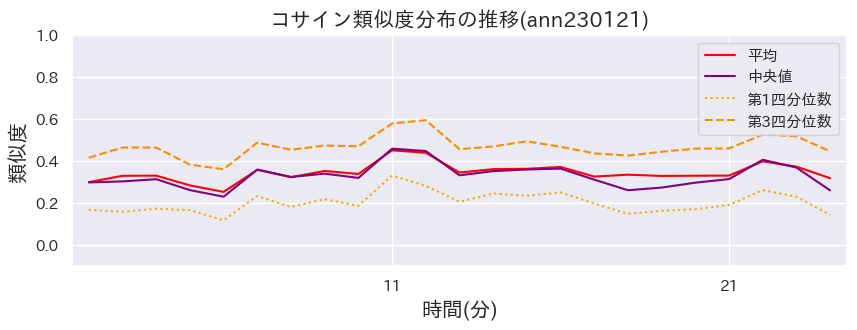

In [17]:
window_sizes = [1]
for window in window_sizes:
    df_vectors['q1'] = df_vectors['q1'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q2'] = df_vectors['q2'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q3'] = df_vectors['q3'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_title(
        "コサイン類似度分布の推移(ann230121)", fontsize=15)
    indices = range(0, len(df_vectors), 10)
    plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows+0.5)
    ax.set_ylim(-0.1, 1)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("類似度", fontsize=15)
    ax.plot(df_vectors["created_at"], df_vectors["mean"], color="red",
            label="平均")
    ax.plot(df_vectors["created_at"], df_vectors["q2"], color="purple",
            label="中央値")
    ax.plot(df_vectors["created_at"], df_vectors["q1"], color="orange", linestyle="dotted",
            label="第1四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["q3"], color="darkorange", linestyle="dashed",
            label="第3四分位数")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    plt.savefig('quantile.png')


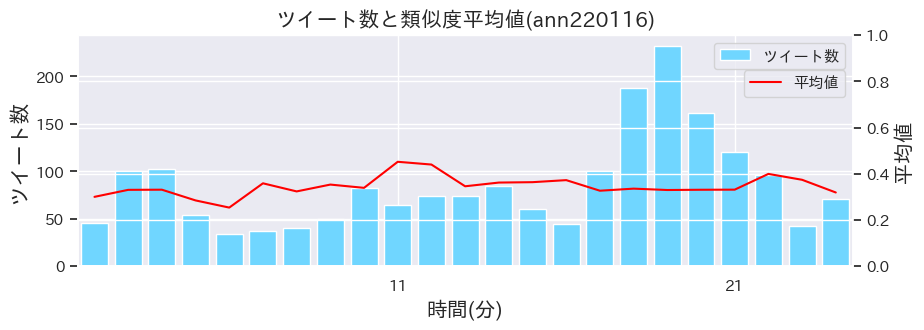

In [18]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    # df_vectors['stdev'] = df_vectors['stdev'].rolling(
    #     window=window, min_periods=1).mean()
    # df_vectors['alpha_m'] = df_vectors['mean'] - df_vectors['stdev']
    # df_vectors['alpha_p'] = df_vectors['mean'] + df_vectors['stdev']

    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_title(
        "ツイート数と類似度平均値(ann220116)", fontsize=15)
    indices = range(0, len(df_vectors), 10)
    plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("平均値", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["mean"], color="red", label="平均値")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_m"], color="orange", linestyle="dashed")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_p"], color="orange", linestyle="dashed",label="68%信頼区間")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.88))
    plt.savefig('mean.png')


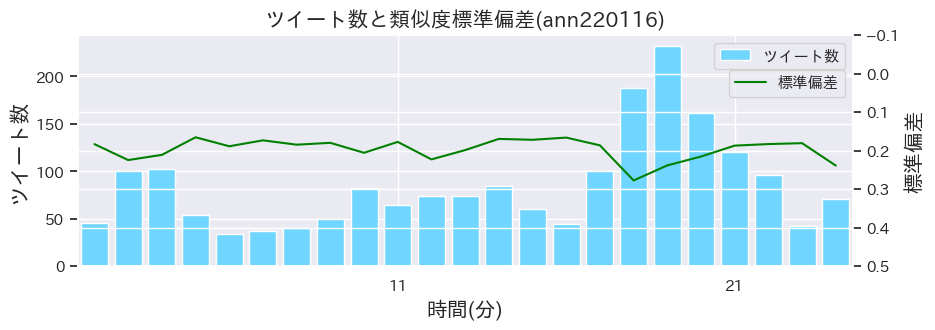

In [19]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['stdev'] = df_vectors['stdev'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_title(
        "ツイート数と類似度標準偏差(ann220116)", fontsize=15)
    indices = range(0, len(df_vectors), 10)
    plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0.5, -0.1)
    ax2.set_ylabel("標準偏差", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["stdev"], color="green",
             label="標準偏差")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.88))
    plt.savefig('stdev.png')
